In [1]:
import numpy as np
import matplotlib.pyplot as plt

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import compute_ridge_loss
from helpers import *
from implementations import *
from preprocessing import *

In [2]:
np.random.seed(2020)

In [3]:
DEGREES = 9

## Make custom pipeline to create polynomial expansion of the features

In [4]:
class PolyPreprocessing(Preprocessing):
    def __init__(self,dataset):
        super().__init__(dataset)
        self.degree = None
        self.cross_degree = None
        
    def set_degrees(self,degree, cross_degree):
        self.degree = degree
        self.cross_degree = cross_degree
        
    def _feature_engineering(self):
        super()._feature_engineering() # to create pipeline
        
        dataset =self.dataset
        
        for deg in range(2,self.degree+1):
            self.dataset = np.concatenate((self.dataset, np.power(dataset,deg)),axis=1)
        
        if (self.cross_degree):
            for col_i in range(dataset.shape[1]):
                print(col_i)
                for col_j in range(col_i+1,dataset.shape[1]):
                    col = dataset[:,col_i]*dataset[:,col_j]
                    self.dataset = np.concatenate((self.dataset,col.reshape((-1,1))),axis=1)

                    
class AddFeaturesPolyPreprocessing(PolyPreprocessing):
    def __init__(self,dataset):
        super().__init__(dataset)
    def _feature_engineering(self):
        super()._feature_engineering()
        X = np.array(self.original_dataset.tolist()) # make unstructured, not very efficient..
        X = X[:,2:] # remove IDs and '?' of predictions
        col = X[:,1]
        f1 = col = 1-np.exp(-col**2/5000).reshape((-1,1))
        self.dataset = np.concatenate((self.dataset,f1),axis=1)      


## Load Datasets


In [5]:
p_train = AddFeaturesPolyPreprocessing(load_csv('../dataset/trainset.csv'))
p_test = AddFeaturesPolyPreprocessing(load_csv('../dataset/testset.csv'))


In [6]:
p_train.set_degrees(DEGREES,1)
p_test.set_degrees(DEGREES,1)
y_train , x_train= p_train.preprocess()
y_test, x_test = p_test.preprocess()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [6]:
import pickle
x_train = pickle.load(open( f"0005_deg{DEGREES}_x_train.p", "rb" ) )
x_test = pickle.load( open( f"0005_deg{DEGREES}_x_test.p", "rb" ) )
y_train = pickle.load(open( f"0005_deg{DEGREES}_y_train.p", "rb" ) )
y_test = pickle.load( open( f"0005_deg{DEGREES}_y_test.p", "rb" ) )
#tx = pickle.load( open(f"0005_deg12_x_predict.p","rb"))

In [7]:
print(x_train.shape)
print(x_test.shape)

(225000, 707)
(25000, 707)


## Prediction with decision boundary

In [8]:
def predict(weight, x_test, boundary = 0.5):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = x_test.dot(weight)
    return (pred > boundary)*1
    

## Ridge Regression on dataset

In [9]:
w, loss = ridge_regression(y_train, x_train,0.004)
#print(w) # gives an idea about the important columns.. 
print(loss)

0.1712540997601487


##  Cross Validation

In [11]:
def build_k_indices(y, k_fold):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def K_Cross_Validation(x, y, K, _lambda):
    #Initialization of all needed arrays
    test_loss = np.zeros(K)
    train_loss = np.zeros(K)
    weights = np.zeros((K,x.shape[1]))
    accuracy = np.zeros(K)
    indices = build_k_indices(y, K)
    
    for i in range(K):
        test_indices = indices[i]
        y_test = y[test_indices]
        y_train = np.delete(y,test_indices)
        x_test = x[test_indices,:]
        x_train = np.delete(x,test_indices,axis=0)
        ### ADAPT METHOD & LOSS
        weights[i], train_loss[i] = ridge_regression(y_train, x_train,_lambda)
        test_loss[i] = compute_ridge_loss(y_test,x_test,weights[i],_lambda)
        
        #Calculate predictions of the model
        predictions = predict(weights[i] , x_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_test) / len(y_test)
        
    return accuracy, test_loss, train_loss, np.mean(weights, axis=0)
        

0.8241822222222223
[2.28098273e+02 1.11581172e+04 4.95482703e+15 8.20596209e-02]
[0.06687771 0.06615934 0.06627536 0.06607303]


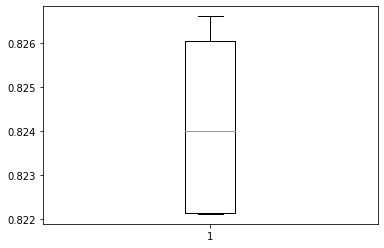

In [12]:
accs,test_loss, train_loss, w = K_Cross_Validation(x_train,y_train,4,0.001)
plt.boxplot(accs)
print(accs.mean())
print(test_loss)
print(train_loss)

## Tune Hyperparameters

In [13]:
def Tune_lambda(xt_training, y_training, K, gamma_range):
        
    lambdas = np.logspace(-7, gamma_range, 10)
    max_acc = 0
    min_loss = np.inf
    opt_lambda = 0
    accuracies = []
    train_losses = []
    test_losses = []
    for i, lambda_ in enumerate(lambdas):
       
        accuracy,test,train,w = K_Cross_Validation(xt_training, y_training, K,lambda_)
        accuracies.append([lambda_,np.median(accuracy)])
        train_losses.append([lambda_,np.median(train)])
        test_losses.append([lambda_,np.median(test)])
        if (np.median(test) < min_loss):
            min_loss = np.median(test)
            max_acc = np.median(accuracy)
            opt_lambda = lambda_
                
    return opt_lambda , max_acc, np.array(accuracies), np.array(train_losses), np.array(test_losses)
opt_lambda, max_acc, acc ,train, test= Tune_lambda(x_train, y_train, 5, 1)

print(f"optimal acc = {max_acc} with lambda= {opt_lambda}")

optimal acc = 0.7478444444444444 with lambda= 1.2915496650148828


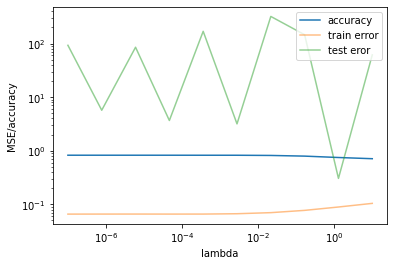

In [14]:

plt.plot(acc[:,0],acc[:,1], label="accuracy")
plt.plot(train[:,0],train[:,1],alpha=0.5,label="train error")
plt.plot(test[:,0],test[:,1],alpha=0.5, label = "test eror")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("MSE/accuracy")
plt.legend(loc="upper right")
plt.show()

model is clearly overfitting, needs to be fixed

## predictions on test set 

In [10]:
w_opt,loss = ridge_regression(y_train,x_train,0.00001)
p = predict(w_opt,x_test)
print((p==y_test).mean())
print(loss)

0.65668
0.17125409976347072


## create submission file


In [16]:
p = AddFeaturesPolyPreprocessing(load_csv('../dataset/test.csv'))
p.set_degrees(DEGREES,1)
ids, tx = p.preprocess(labeled=False)

prediction data
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [26]:
p = predict(w_opt,tx)


In [27]:
create_csv_submission(ids, p, f"model_0005_deg{DEGREES}.csv")

## store dataset in pickle


In [19]:
#import pickle
#pickle.dump( x_train, open( f"0005_deg{DEGREES}_x_train.p", "wb" ) )
#pickle.dump( x_test, open( f"0005_deg{DEGREES}_y_test.p", "wb" ) )
#pickle.dump( y_train, open( f"0005_deg{DEGREES}_y_train.p", "wb" ) )
#pickle.dump( y_test, open( f"0005_deg{DEGREES}_y_test.p", "wb" ) )
#pickle.dump( tx, open(f"0005_deg{DEGREES}_x_predict.p","wb"))



In [20]:
w_opt

array([ 1.14497101e-02,  7.67147305e-03, -1.87827798e-02,  5.06321136e-03,
        1.22348737e-03,  8.00750698e-04,  4.51566585e-04, -1.80112984e-03,
        6.48436652e-03, -2.69642409e-03,  4.17529352e-04, -1.41904634e-02,
        2.84216697e-03,  1.64700587e-03,  1.40496968e-02, -2.32125942e-04,
       -3.17567588e-04, -1.59139551e-03, -2.44255801e-05,  6.51599424e-04,
       -6.16484063e-03,  1.11913165e-04,  4.29184893e-04, -4.88920169e-03,
        1.27356533e-03, -1.87134530e-04, -1.71785857e-04,  8.98748998e-04,
       -2.54765762e-06, -7.00000937e-05, -2.35970660e-03, -9.71862657e-03,
        8.37943752e-03, -7.81565456e-03,  6.77748361e-03,  1.40939945e-03,
        1.19917976e-03, -2.06608628e-04,  3.61527436e-03,  4.35291519e-03,
        1.49185470e-03,  7.73251990e-03,  9.27605245e-03,  4.03535650e-04,
        4.59870151e-03,  2.97729154e-03,  7.22337978e-03,  3.26221006e-03,
        2.26833819e-03,  8.09967153e-03,  8.22324850e-03,  7.49346543e-03,
        6.57560183e-04,  